In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

# Example code from Dr. Tward

In [2]:
nrows = 64
ncols = 65 
# in test cases I make rows and columns different numbers
# in case there are any bugs where we mix up rows and columns

<IPython.core.display.Javascript object>


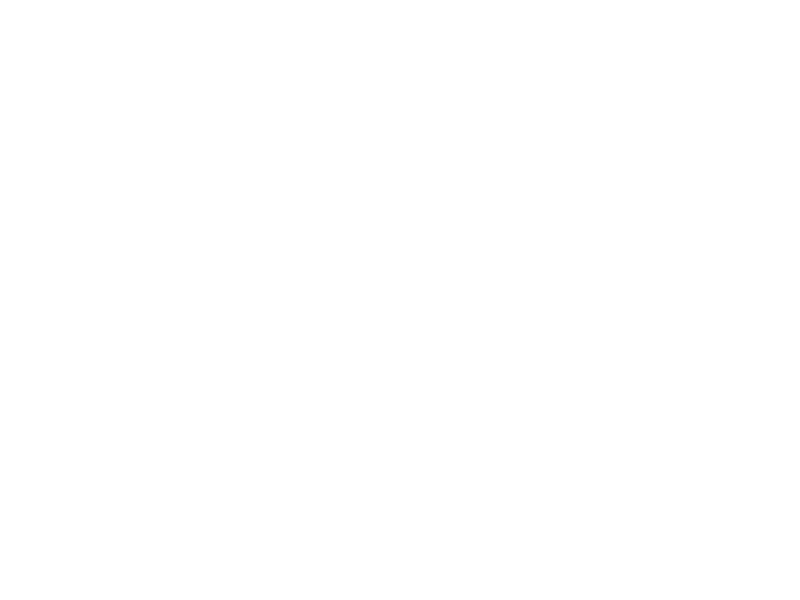

In [3]:
# initialize an image
I = np.zeros((nrows,ncols))

# draw it
fig,ax = plt.subplots()
ax.imshow(I,cmap='gray')

<IPython.core.display.Javascript object>


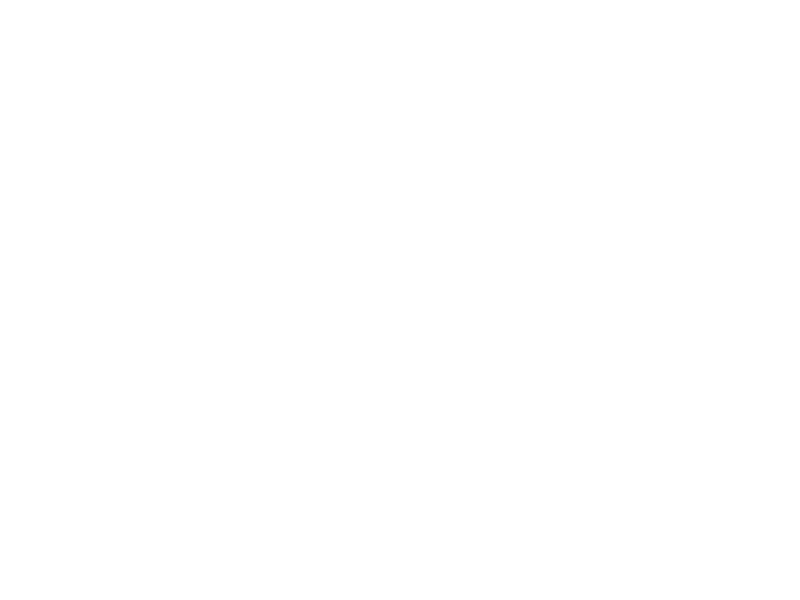

In [4]:
# get the locations of every pixel so we can insert cells at certain locations
r = np.arange(nrows)
c = np.arange(ncols)
r,c
# to get the row and column of every pixel, we use meshgrid
R,C = np.meshgrid(r,c,indexing='ij')
fig,ax = plt.subplots(1,2)
ax[0].imshow(R)
ax[1].imshow(C)
# R stores the row of every pixel, and C stores the column of every pixel

In [5]:
# let's put a cell at the location (20,30)
radius = 5
I += (R - 20)**2 + (C - 30)**2 <= radius**2

<IPython.core.display.Javascript object>


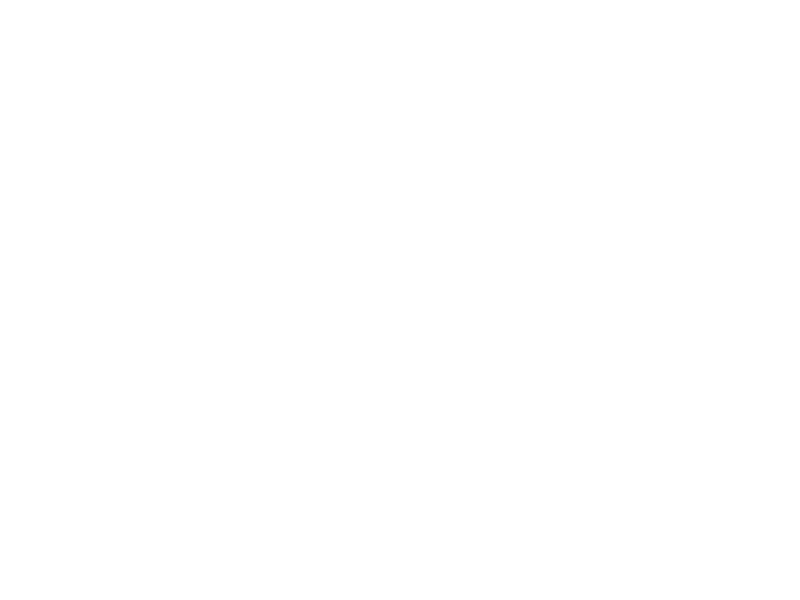

In [6]:
fig,ax = plt.subplots()
ax.imshow(I,cmap='gray')

# Creation of Simulated Images

In [7]:
# goal is to repeat this so that you have a bunch of cells in two different images, covering the four cases

<IPython.core.display.Javascript object>


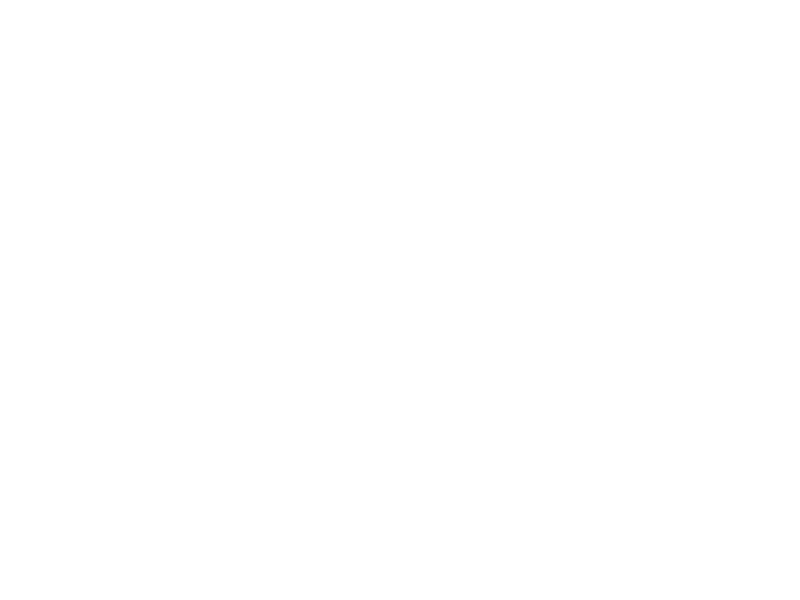

In [8]:
nrows = 128
ncols = 129

# initialize empty images
I1 = np.zeros((nrows,ncols))
I2 = np.zeros((nrows,ncols))

# to get the row and column of every pixel, we use meshgrid
r = np.arange(nrows)
c = np.arange(ncols)
R,C = np.meshgrid(r,c,indexing='ij')

# Constant radius across all cells
radius = 8

# Define coordinate center of each gt cell
cellPos = np.array([[20,30],[100,80],[60,20],[110,40],[50,60],[20,120],[15,70],[70,90],[40,40],[80,20],[90,60],[40,110],[12,99]])
cellIDs = np.arange(1,len(cellPos)+1,1)

# Insertion of cells onto empty image
for coords,id_number in zip(cellPos,cellIDs):
    I1 += ((R - coords[0])**2 + (C - coords[1])**2 <= radius**2)*id_number

# Definition of predicted cell
cirPos = np.array([[10,10],[98,77],[50,18],[110,30],[14,68],[60,110],[36,36],[78,18],[92,55],[41,110],[30,90]])
cirIDs = np.arange(1,len(cirPos)+1,1)

# Insertion of bounding boxes onto cell image
# I2 = I1.copy()
for coords,id_number in zip(cirPos,cirIDs):
    I2 += ((R - coords[0])**2 + (C - coords[1])**2 <= radius**2)*id_number

I1 = I1.astype(int)
I2 = I2.astype(int)

# Display GT and Prediction images
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.title.set_text('Ground Truth')
ax1.imshow(I1,cmap='gray')
ax2.title.set_text('Predictions')
ax2.imshow(I2,cmap='gray')

<IPython.core.display.Javascript object>


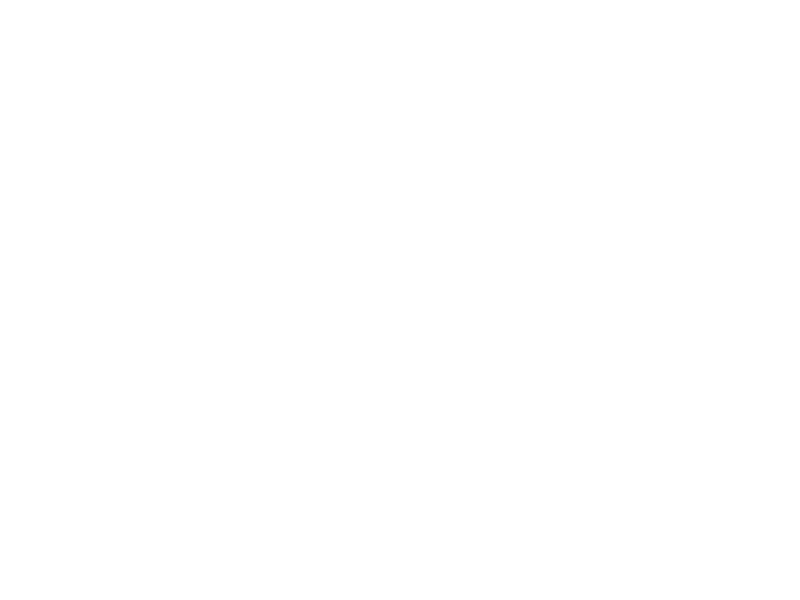

In [9]:
fig,ax = plt.subplots()
ax.title.set_text('GT + Prediction')
ax.imshow(I1+I2)

Case 1: a good match, where they agree almost completely
- GT cell located at [15,70], [100,80], [80,20], [40,110]
- Predict located at [14,68], [98,77],  [78,18], [41,110]

Case 2: a bad match, where they overlap only partially
- GT cell located at [60,20], [110,40], [40,40], [90,60]
- Predict located at [50,18], [110,30], [36,36], [92,55]

Case 3: a false positive, where a predicted cell is in the wrong spot
- GT cell located at [20,30], [70,90]
- Predict located at [10,10], [60,110], [30,90]

Case 4: a false negative, where a ground truth cell is missed completely
- GT cell located at [50,60], [20,120], [12,99]

## Calculation of Precision and Recall

Metric definitions:
- TP: A point **DOES** have a cell and was **CORRECTLY** predicted
- TN: A point does **NOT** have a cell and was **CORRECTLY** predicted
- FP: A point does **NOT** have a cell and was **INCORRECTLY** predicted
- FN: A point **DOES** have a cell and was **INCORRECTLY** predicted

In [10]:
def metrics(I1,I2):
    if I1.shape != I2.shape:
        print("Error: Invalid input shape")
        return 0
    
    TP,TN,FP,FN = [0,0,0,0]

    for rVal in np.arange(I1.shape[0]):
        for cVal in np.arange(I1.shape[1]):
            i1 = I1[rVal][cVal]
            i2 = I2[rVal][cVal]

            if i1 > 0 and i2 > 0:
                TP+=1
            elif i1 == 0 and i2 == 0:
                TN+=1
            elif i1 == 0 and i2 > 0:
                FP+=1
            elif i1 > 0 and i2 == 0:
                FN+=1
            else:
                print('Missed case: (%i,%i)',i1,i2) 

    return [TP,TN,FP,FN]

def accuracy (TP,TN,FP,FN):
    return (TP+TN) / (TP+TN+FP+FN)

def precision(TP,FP):
    return TP / (TP+FP)

def recall(TP,FN):
    return TP / (TP+FN)

def fpr(FP,TN):
    return FP / (FP+TN)

def f1score(TP,FP,FN):
    return 2*recall(TP,FN)*precision(TP,FP)/(recall(TP,FN)+precision(TP,FP))

In [11]:
[TP,TN,FP,FN] = metrics(I1,I2)

print('accuracy:',accuracy(TP,TN,FP,FN))
print('precision:',precision(TP,FP))
print('recall:',recall(TP,FN))
print('fpr:',fpr(FP,TN))
print('f1score:',f1score(TP,FP,FN))

accuracy: 0.8292151162790697
precision: 0.44023996308260266
recall: 0.3725107379929715
fpr: 0.08694717224571716
f1score: 0.40355329949238583


## Bounding boxes over GT image

<IPython.core.display.Javascript object>


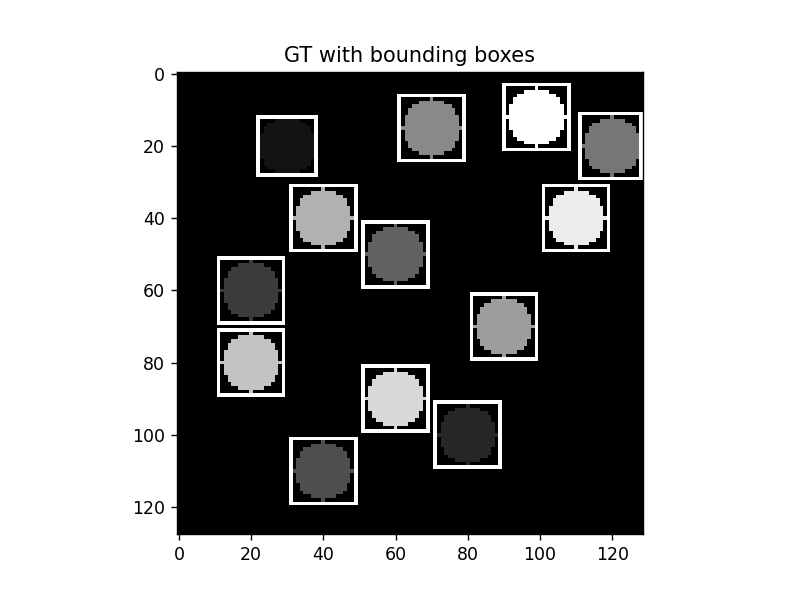

In [12]:
# Tutorial from https://muthu.co/draw-bounding-box-around-contours-skimage/

from skimage.measure import find_contours
from skimage.io import imread
%matplotlib notebook
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from skimage.draw import polygon_perimeter

# Image must be converted to grayscale before calling find_contours()
contours = find_contours(I1, 0.8)

# Generate bounding boxes of the form [Xmin, Xmax, Ymin, Ymax]
bounding_boxes = []

for contour in contours:
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    
    bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])

# Creates copy of original grayscale image, which will be
with_boxes  = np.copy(I1)

for box in bounding_boxes:
    #[Xmin, Xmax, Ymin, Ymax]
    r = [box[0],box[1],box[1],box[0], box[0]]
    c = [box[3],box[3],box[2],box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc] = np.amax(I1) #set box to highest int in image

fig,ax1 = plt.subplots();
ax1.title.set_text('GT with bounding boxes');
ax1.imshow(with_boxes,cmap='gray');

## Bounding boxes on GT + Predicted image

<IPython.core.display.Javascript object>


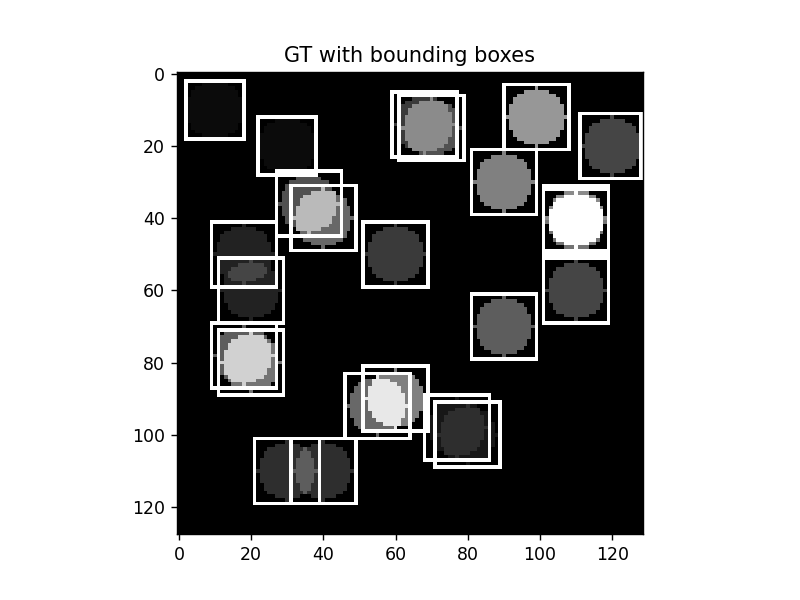

In [13]:
# Image must be converted to grayscale before calling find_contours()
contours_gt = find_contours(I1, 0.8)
contours_pred = find_contours(I2, 0.8)

# Generate bounding boxes of the form [Xmin, Xmax, Ymin, Ymax]
bounding_boxes_gt = []
bounding_boxes_pred = []

for contour in contours_gt:
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    
    bounding_boxes_gt.append([Xmin, Xmax, Ymin, Ymax])
    
for contour in contours_pred:
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    
    bounding_boxes_pred.append([Xmin, Xmax, Ymin, Ymax])

# Creates copy of original grayscale image, which will be
with_boxes  = np.copy(I1+I2)

for box in bounding_boxes_gt:
    #[Xmin, Xmax, Ymin, Ymax]
    r = [box[0],box[1],box[1],box[0], box[0]]
    c = [box[3],box[3],box[2],box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc] = np.amax(I1+I2) #set box to highest int in image
    
for box in bounding_boxes_pred:
    #[Xmin, Xmax, Ymin, Ymax]
    r = [box[0],box[1],box[1],box[0], box[0]]
    c = [box[3],box[3],box[2],box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc] = np.amax(I1+I2) #set box to highest int in image

fig,ax2 = plt.subplots();
ax2.title.set_text('GT with bounding boxes');
ax2.imshow(with_boxes,cmap='gray');

In [14]:
'''
box1 and box2 are bounding boxes of the form [rMin, rMax, cMin, cMax]
'''
def IOU(box1,box2):
    # determine the (r, c)-coordinates of the intersection rectangle
    c1 = max(box1[2], box2[2])
    r1 = max(box1[0], box2[0])
    c2 = min(box1[3], box2[3])
    r2 = min(box1[1], box2[1])

    # compute the area of intersection rectangle
    interArea = abs(max((c2 - c1, 0)) * max((r2 - r1), 0))
    if interArea == 0:
        return 0
    
    box1area = (box1[3]-box1[2])*(box1[1]-box1[0])
    box2area = (box2[3]-box2[2])*(box2[1]-box2[0])

    union = box1area+box2area-interArea
    
    return interArea/union

In [15]:
for bbg in bounding_boxes_gt:
    for bbp in bounding_boxes_pred:
        if IOU(bbg,bbp) > 0:
            print(f"IOU:{IOU(bbg,bbp)}\nbbg:{bbg}\nbbp:{bbp}")
            print()

IOU:0.7198592436419065
bbg:[6.114285714285714, 23.885714285714286, 61.114285714285714, 78.88571428571429]
bbp:[5.16, 22.84, 59.16, 76.84]

IOU:0.021014344028642447
bbg:[11.8, 28.2, 21.8, 38.2]
bbp:[27.114285714285714, 44.885714285714286, 27.114285714285714, 44.885714285714286]

IOU:0.42958959747977604
bbg:[31.08888888888889, 48.91111111111111, 31.08888888888889, 48.91111111111111]
bbp:[27.114285714285714, 44.885714285714286, 27.114285714285714, 44.885714285714286]

IOU:0.8926534826127982
bbg:[31.066666666666666, 48.93333333333333, 101.06666666666666, 118.93333333333334]
bbp:[32.08, 49.92, 101.08, 118.92]

IOU:0.23345072953352983
bbg:[51.266666666666666, 68.73333333333333, 11.266666666666667, 28.733333333333334]
bbp:[41.266666666666666, 58.733333333333334, 9.266666666666667, 26.733333333333334]

IOU:0.6503399394854704
bbg:[71.08, 88.92, 11.08, 28.92]
bbp:[69.1, 86.9, 9.1, 26.9]

IOU:0.46952200640800795
bbg:[81.07272727272728, 98.92727272727272, 51.07272727272727, 68.92727272727272]
bbp:

### Helper Functions for Performance Calculation

In [16]:
'''
- Ignore TP in gt (to avoid double-counting)
- There are no FP in bbgt and no FN in bbpred
'''
def count_metrics(bbgt,bbpred,cVal):
    TPgt,FPgt,FNgt = count_metrics_help(bbgt,"GT",cVal)
    TPpred,FPpred,FNpred = count_metrics_help(bbpred,"Pred",cVal)
    return TPpred,FPpred,FNgt

def count_metrics_help(bb_set,bbType,cVal):
    countTP = 0;
    countFP = 0;
    countFN = 0;
    for bb in bb_set:
        if bb[1][2] > cVal:
            if bb[1][1]=="TP":
                countTP+=1
            elif bb[1][1]=="FP":
                countFP+=1
            elif bb[1][1]=="FN":
                countFN+=1
            else:
                print("ERROR in count_metrics_help(): Invalid label in",bbType," : ",bb[1][1])
                print(bb); print()
    return countTP, countFP, countFN

def sumIOU(bbgt,bbpred):
    return sumIOU_help(bbgt)+sumIOU_help(bbpred)

def sumIOU_help(bb_set):
    IOU = 0
    for bb in bb_set:
        IOU += bb[1][0]
    return IOU

### Performance Calculation

Average Precision: 0.4824737762237763


<IPython.core.display.Javascript object>


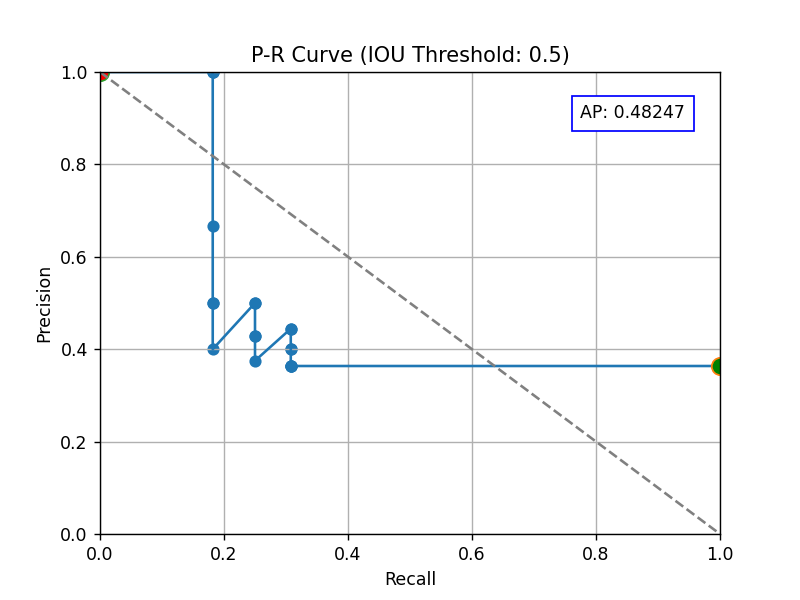

In [61]:
# Parameters to tweak for simulated P-R curve look nice: random seed number, range of confidences, iouThreshold

import random
from sklearn.metrics import auc

# Creates "empty" labels for each bb from the ground truth and predicted sets
# + Assumes 11 predictions were made
gt_label = [[-1,"Unclassified",1]]*len(bounding_boxes_gt)
pred_label = [[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1],[-1,"Unclassified",-1]]

# Generates fixed random confidence values (from 0.2-0.99) for each prediction
random.seed(9)
cInt = random.sample(range(20,100),len(pred_label))
cFloat = [float(x) for x in cInt]
cFloat = [x/100 for x in cFloat]
for i in range(len(cFloat)):
    pred_label[i][2] = cFloat[i]

# Correlate all g_i with p_j whose IOU(g_i, p_j) is the largest
iouThresh = 0.5

# Create new (empty) data structure for each bb: [bbcoords,[IOU, classification, confidence]]
G = list(map(list,zip(bounding_boxes_gt,gt_label)))
P = list(map(list,zip(bounding_boxes_pred,pred_label)))    
for gi in G:
    prev_gi_label = gi[1]
    maxIOU_gi_pj = 0
    best_pj = None
    for pj in P:
        if IOU(gi[0],pj[0]) > iouThresh and IOU(gi[0],pj[0]) > maxIOU_gi_pj:
            maxIOU_gi_pj = IOU(gi[0],pj[0])
            best_pj = pj
    if maxIOU_gi_pj > 0:
        gi[1] = [maxIOU_gi_pj,"TP",gi[1][2]]
        best_pj[1] = [maxIOU_gi_pj,"TP",best_pj[1][2]]
    if prev_gi_label == gi[1]:
        gi[1] = [0,"FN",gi[1][2]]
for pi in P:
    if pi[1][1] == "Unclassified":
        pi[1] = [0,"FP",pi[1][2]]
            
# Defines empty lists to store precision and recall values
precision = []
recall = []

# Loop over each threshold value from 0 to 1 with a step of 0.05
cRange = np.arange(0,1.0,0.05)
for Tk in cRange:
    # Compute and store metrics at confidence threshold Tk
    TP, FP, FN = count_metrics(G,P,Tk)
    #print(TP,FP,FN)
    
    if TP+FP == 0:
        precVal = 0
    else:
        precVal = TP/(TP+FP)
    precision.append(precVal)
    
    if TP+FN == 0:
        recVal = 0
    else:
        recVal = TP/(TP+FN)
    recall.append(recVal)

# ===== Portion of algorithm used by sklearn.metrics.precision_recall_curve(*)
# Extends left of P-R curve to (p,r) = (1,0)
precision.append(1.0)
recall.append(0.0)

# Extends right of P-R curve to (p,r) = (class balance,1)
precision.insert(0,min(precision))
recall.insert(0,1.0)
# =====

# Computes Average Precision the same way as sklearn.metrics.average_precision_score(*)
AP = 0
for i in np.arange(1,len(precision)):
    AP += np.abs(recall[i]-recall[i-1])*precision[i]
print(f"Average Precision: {AP}")

# Generates a "baseline" to which we can compare our model's performance
baseX = np.linspace(0.0,1.0)
baseY = -baseX+1

# Plots the P-R Curve, baseline performance, start (green), and end (red) points
fig,ax = plt.subplots()
ax.plot(recall,precision)
ax.scatter(recall,precision)
ax.plot(recall[0], precision[0], marker="o", markersize=10, markerfacecolor="green")
ax.plot(recall[-1], precision[-1], marker="o", markersize=10, markerfacecolor="red")
ax.plot(baseX, baseY,color="gray",ls="--")
ax.text(0.775,0.9,f"AP: {round(AP,5)}",bbox=dict(facecolor='white', edgecolor='blue', pad=5.0))
ax.grid()
ax.set_title(f'P-R Curve (IOU Threshold: {iouThresh})');
ax.set_xlabel("Recall"); ax.set_xlim(0, 1);
ax.set_ylabel("Precision"); ax.set_ylim(0, 1);

In [40]:
list(zip(precision,recall))

[(0.36363636363636365, 1.0),
 (0.36363636363636365, 0.3076923076923077),
 (0.36363636363636365, 0.3076923076923077),
 (0.36363636363636365, 0.3076923076923077),
 (0.36363636363636365, 0.3076923076923077),
 (0.4, 0.3076923076923077),
 (0.4, 0.3076923076923077),
 (0.4444444444444444, 0.3076923076923077),
 (0.4444444444444444, 0.3076923076923077),
 (0.375, 0.25),
 (0.42857142857142855, 0.25),
 (0.42857142857142855, 0.25),
 (0.5, 0.25),
 (0.5, 0.25),
 (0.4, 0.18181818181818182),
 (0.5, 0.18181818181818182),
 (0.5, 0.18181818181818182),
 (0.6666666666666666, 0.18181818181818182),
 (1.0, 0.18181818181818182),
 (1.0, 0.18181818181818182),
 (1.0, 0.18181818181818182),
 (1.0, 0.0)]

In [39]:
print(len(precision))
print(len(cRange))

22
20


In [46]:
AP = 0
for i in np.arange(1,len(precision)):
    AP += np.abs(recall[i]-recall[i-1])*precision[i]
    
AP

0.4824737762237763